# Hierarchical Bayesian neural networks

Code is based on  [This blog post](https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/) by Thomas Wiecki.
[Original PyMC3 Notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network_hierarchical.ipynb). Converted to Blackjax by Aleyna Kara (@karalleyna) and Kevin Murphy (@murphyk). (For a Numpyro version, see [here](https://github.com/probml/probml-notebooks/blob/main/notebooks/bnn_hierarchical_numpyro.ipynb).)

We create T=18 different versions of the "two moons" dataset, each rotated by a different amount. These correspond to T different nonlinear binary classification "tasks" that we have to solve. We only get a few labeled samples from each each task, so solving them separately (with T independent MLPs, or multi layer perceptrons) will result in poor performance. If we pool all the data, and fit a single MLP, we also get poor performance, because we are mixing together different decision boundaries. But if we use a hierarchical Bayesian model, with one MLP per task, and one learned prior MLP,  we will get better results, as we will see.






Below is a high level illustration of the multi-task setup. $\Phi$ is the learned prior, and $\Theta_t$ are the parameters for task $t$. We assume $N^t=50$ training samples per task, and $M^t=50$ test samples. (We could of course consider more imbalanced scenarios.)






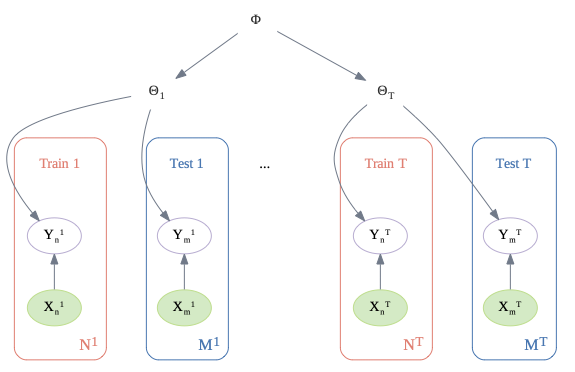

## Setup

In [1]:
from warnings import filterwarnings

import jax
from jax import vmap, jit
import jax.numpy as jnp
from jax.random import PRNGKey, split, normal
import jax.random as random
import numpy as np

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt
    %pip install -qq blackjax
    import blackjax

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    import tensorflow_probability.substrates.jax.distributions as tfd
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability.substrates.jax.distributions as tfd

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from functools import partial

try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

filterwarnings("ignore")
sns.set_style("white")

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

2022-07-19 05:04:32.079480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Note: you may need to restart the kernel to use updated packages.


## Data

We create T=18 different versions of the "two moons" dataset, each rotated by a different amount. These correspond to T different binary classification "tasks" that we have to solve. 


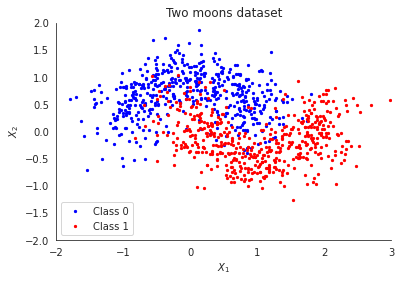

In [2]:
X, Y = make_moons(noise=0.3, n_samples=1000)

latexify(width_scale_factor=2, fig_height=2.75)
figsize = (15, 12)
s = 20
if is_latexify_enabled():
    figsize = None
    s = 5

plt.figure()
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], color="b", label="Class 0", s=5)
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1", s=5)
sns.despine()
plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.legend(loc="lower left")
plt.title("Two moons dataset")
savefig("Two_moons_synthetic_dataset")
plt.show()

In [3]:
n_groups = 18
if is_latexify_enabled():
    n_groups = 4

n_grps_sq = int(np.sqrt(n_groups))
n_samples = 100

In [4]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

In [5]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.0
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [6]:
Xs = jnp.stack(Xs)
Ys = jnp.stack(Ys)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

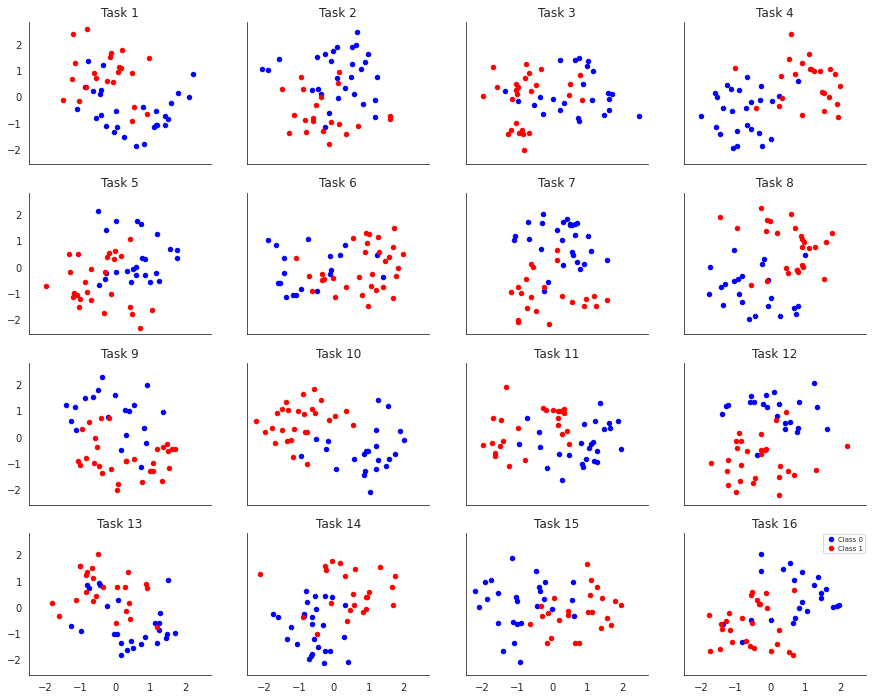

In [7]:
figsize = (15, 12)
s = 20
if is_latexify_enabled():
    figsize = None
    s = 5
latexify(width_scale_factor=2, fig_height=2.75)
fig, axs = plt.subplots(figsize=figsize, nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="b", s=s, label="Class 0")
    ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", s=s, label="Class 1")
    sns.despine()
    ax.set_title("Task {}".format(i + 1))
ax.legend(fontsize=7, borderaxespad=0.2, handletextpad=0, borderpad=0.2)
savefig("Tasks", tight_layout=False, tight_bbox=False)

In [8]:
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)

## Utility functions for training and testing

In [12]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def get_predictions(model, samples, X, n_hidden_layers, rng_key, num_samples):
    samples_flattened, tree_def = jax.tree_flatten(samples)
    keys = random.split(rng_key, num_samples)
    predictions = []

    for i, key in enumerate(keys):
        params = {}
        for j, k in enumerate(samples.keys()):
            params[k] = samples_flattened[j][i]

        z = model(params, X, n_hidden_layers)
        Y = distrax.Bernoulli(logits=z).sample(seed=key)
        predictions.append(Y[None, ...])

    return jnp.vstack(predictions)


def get_mean_predictions(predictions, threshold=0.5):
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold


def fit_and_eval(rng_key, model, potential_fn, X_train, Y_train, X_test, grid, n_groups=None):
    init_key, warmup_key, inference_key, train_key, test_key, grid_key = split(rng_key, 6)

    # initialization
    potential = partial(potential_fn, X=X_train, Y=Y_train, model=model, n_hidden_layers=n_hidden_layers)
    initial_position = (
        init_bnn_params(layer_widths, init_key)
        if n_groups is None
        else init_hierarchical_params(layer_widths, n_groups, init_key)
    )

    # warm up
    adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
    final_state, nuts_kernel, _ = adapt.run(warmup_key, initial_position)

    # inference
    states = inference_loop(inference_key, nuts_kernel, final_state, num_samples)
    samples = states.position

    # evaluation
    predictions = get_predictions(model, samples, X_train, n_hidden_layers, train_key, num_samples)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, n_hidden_layers, test_key, num_samples)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, n_hidden_layers, grid_key, num_samples)

    return Y_pred_train, Y_pred_test, pred_grid

## Hyperparameters

We use an MLP with 2 hidden layers, each with 5 hidden units.


In [13]:
# MLP params
layer_widths = [Xs_train.shape[-1], 5, 5, 1]
n_hidden_layers = len(layer_widths) - 2

In [14]:
# MCMC params
num_warmup = 1500
num_samples = 500

## Fit separate MLPs, one per task

Let $w^t_{ijl}$ be  the weight for node $i$ to node $j$ in layer $l$ in task $t$. We assume
$$
w^t_{ijl} \sim N(0,1) 
$$
and compute the posterior for all the weights.


In [15]:
def init_bnn_params(layer_widths, rng_key):
    rng_key, *keys = split(rng_key, len(layer_widths))
    params = {}

    for i, (n_in, n_out, key) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys)):
        params[f"w_{i}"] = distrax.Normal(0, 1).sample(seed=key, sample_shape=(n_in, n_out))

    return params

In [16]:
def bnn(params, X, n_hidden_layers):
    z = X

    for i in range(n_hidden_layers + 1):
        z = z @ params[f"w_{i}"]
        z = jax.nn.tanh(z) if i != n_hidden_layers else z

    z = z.squeeze(-1)
    return z

In [17]:
def logprob_fn_of_bnn(params, X, Y, model, n_hidden_layers):
    log_joint = 0

    for i in range(n_hidden_layers + 1):
        log_joint += distrax.Normal(0.0, 1.0).log_prob(params[f"w_{i}"]).sum()

    z = model(params, X, n_hidden_layers)
    loglikelihood = distrax.Bernoulli(logits=z).log_prob(Y).sum()
    log_joint += loglikelihood

    return jnp.sum(log_joint)

In [18]:
rng_key = PRNGKey(0)
keys = split(rng_key, n_groups)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(key, bnn, logprob_fn_of_bnn, X_train, Y_train, X_test, grid, n_groups=None)


Ys_pred_train, Ys_pred_test, ppc_grid_single = vmap(fit_and_eval_single_mlp)(keys, Xs_train, Ys_train, Xs_test)

### Results

Accuracy is reasonable, but the decision boundaries have not captured the underlying Z pattern in the data, due to having too little data per task. (Bayes model averaging results in a simple linear decision boundary, and prevents overfitting.)

In [19]:
print("Train accuracy = {:.2f}%".format(100 * jnp.mean(Ys_pred_train == Ys_train)))

Train accuracy = 86.56%


In [20]:
print("Test accuracy = {:.2f}%".format(100 * jnp.mean(Ys_pred_test == Ys_test)))

Test accuracy = 83.67%


In [21]:
def plot_decision_surfaces_non_hierarchical(nrows=1, ncols=4, fname=None):
    figsize = (ncols * 3, nrows * 3)
    s = 20
    if is_latexify_enabled():
        figsize = None
        s = 5
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    axes = axes.flatten()
    for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axes)):
        contour = ax.contourf(
            grid[:, 0].reshape(100, 100),
            grid[:, 1].reshape(100, 100),
            ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100),
            cmap=cmap,
        )
        ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], s=s, color="b", label="Class 0")
        ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], s=s, color="r", label="Class 1")
        sns.despine()
        ax.set_title("Dataset " + str(i + 1))
    if fname:
        ax.legend(borderaxespad=0.2, handletextpad=0, borderpad=0.2, handlelength=1.5, fontsize=7)
        savefig(fname, tight_layout=False)
    else:
        ax.legend()

Below we show that the decision boundaries do not look reasonable, since there is not enough data to fit each model separately.


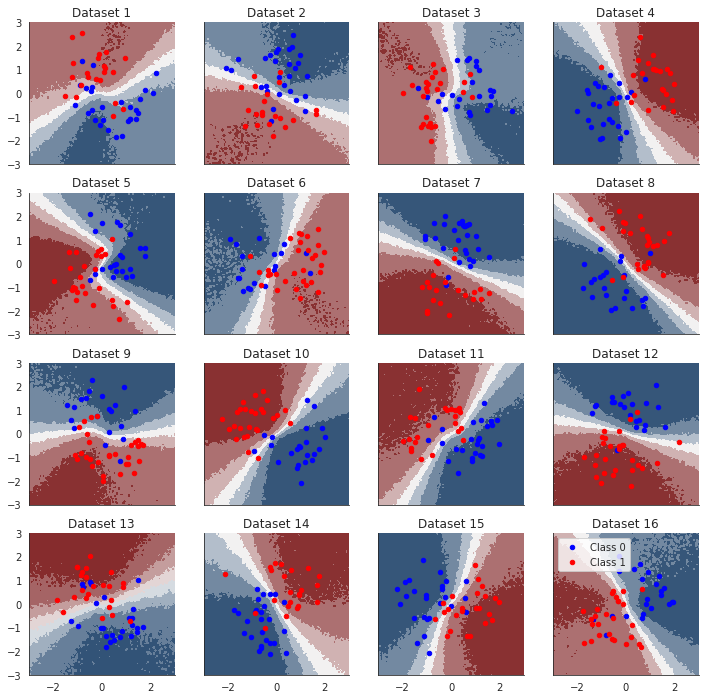

In [22]:
plot_decision_surfaces_non_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

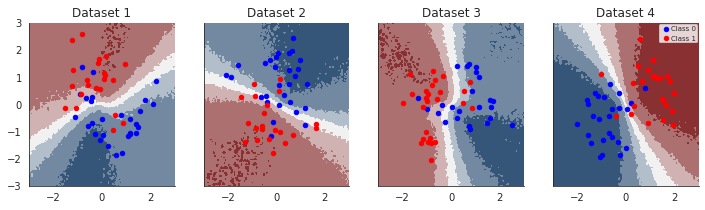

In [23]:
plot_decision_surfaces_non_hierarchical(fname="Decision_surfaces_non_hierarchical")

## Hierarchical Model

Now we use a hierarchical Bayesian model, which has a common Gaussian prior for all the weights, but allows each task to have its own task-specific parameters. More precisely, let $w^t_{ijl}$ be  the weight for node $i$ to node $j$ in layer $l$ in task $t$. We assume
$$
w^t_{ijl} \sim N(\mu_{ijl}, \sigma_l) 
$$

$$
\mu_{ijl} \sim N(0,1) 
$$

$$
\sigma_l \sim N_+(0,1)
$$

or, in non-centered form,
$$
w^t_{ijl} = \mu_{ijl} + \epsilon^t_{ijl} \sigma_l
$$

In the figure below, we illustrate this prior, using an MLP with D inputs, 2 hidden layers (of size $L_1$ and $L_2$), and a scalar output (representing the logit).

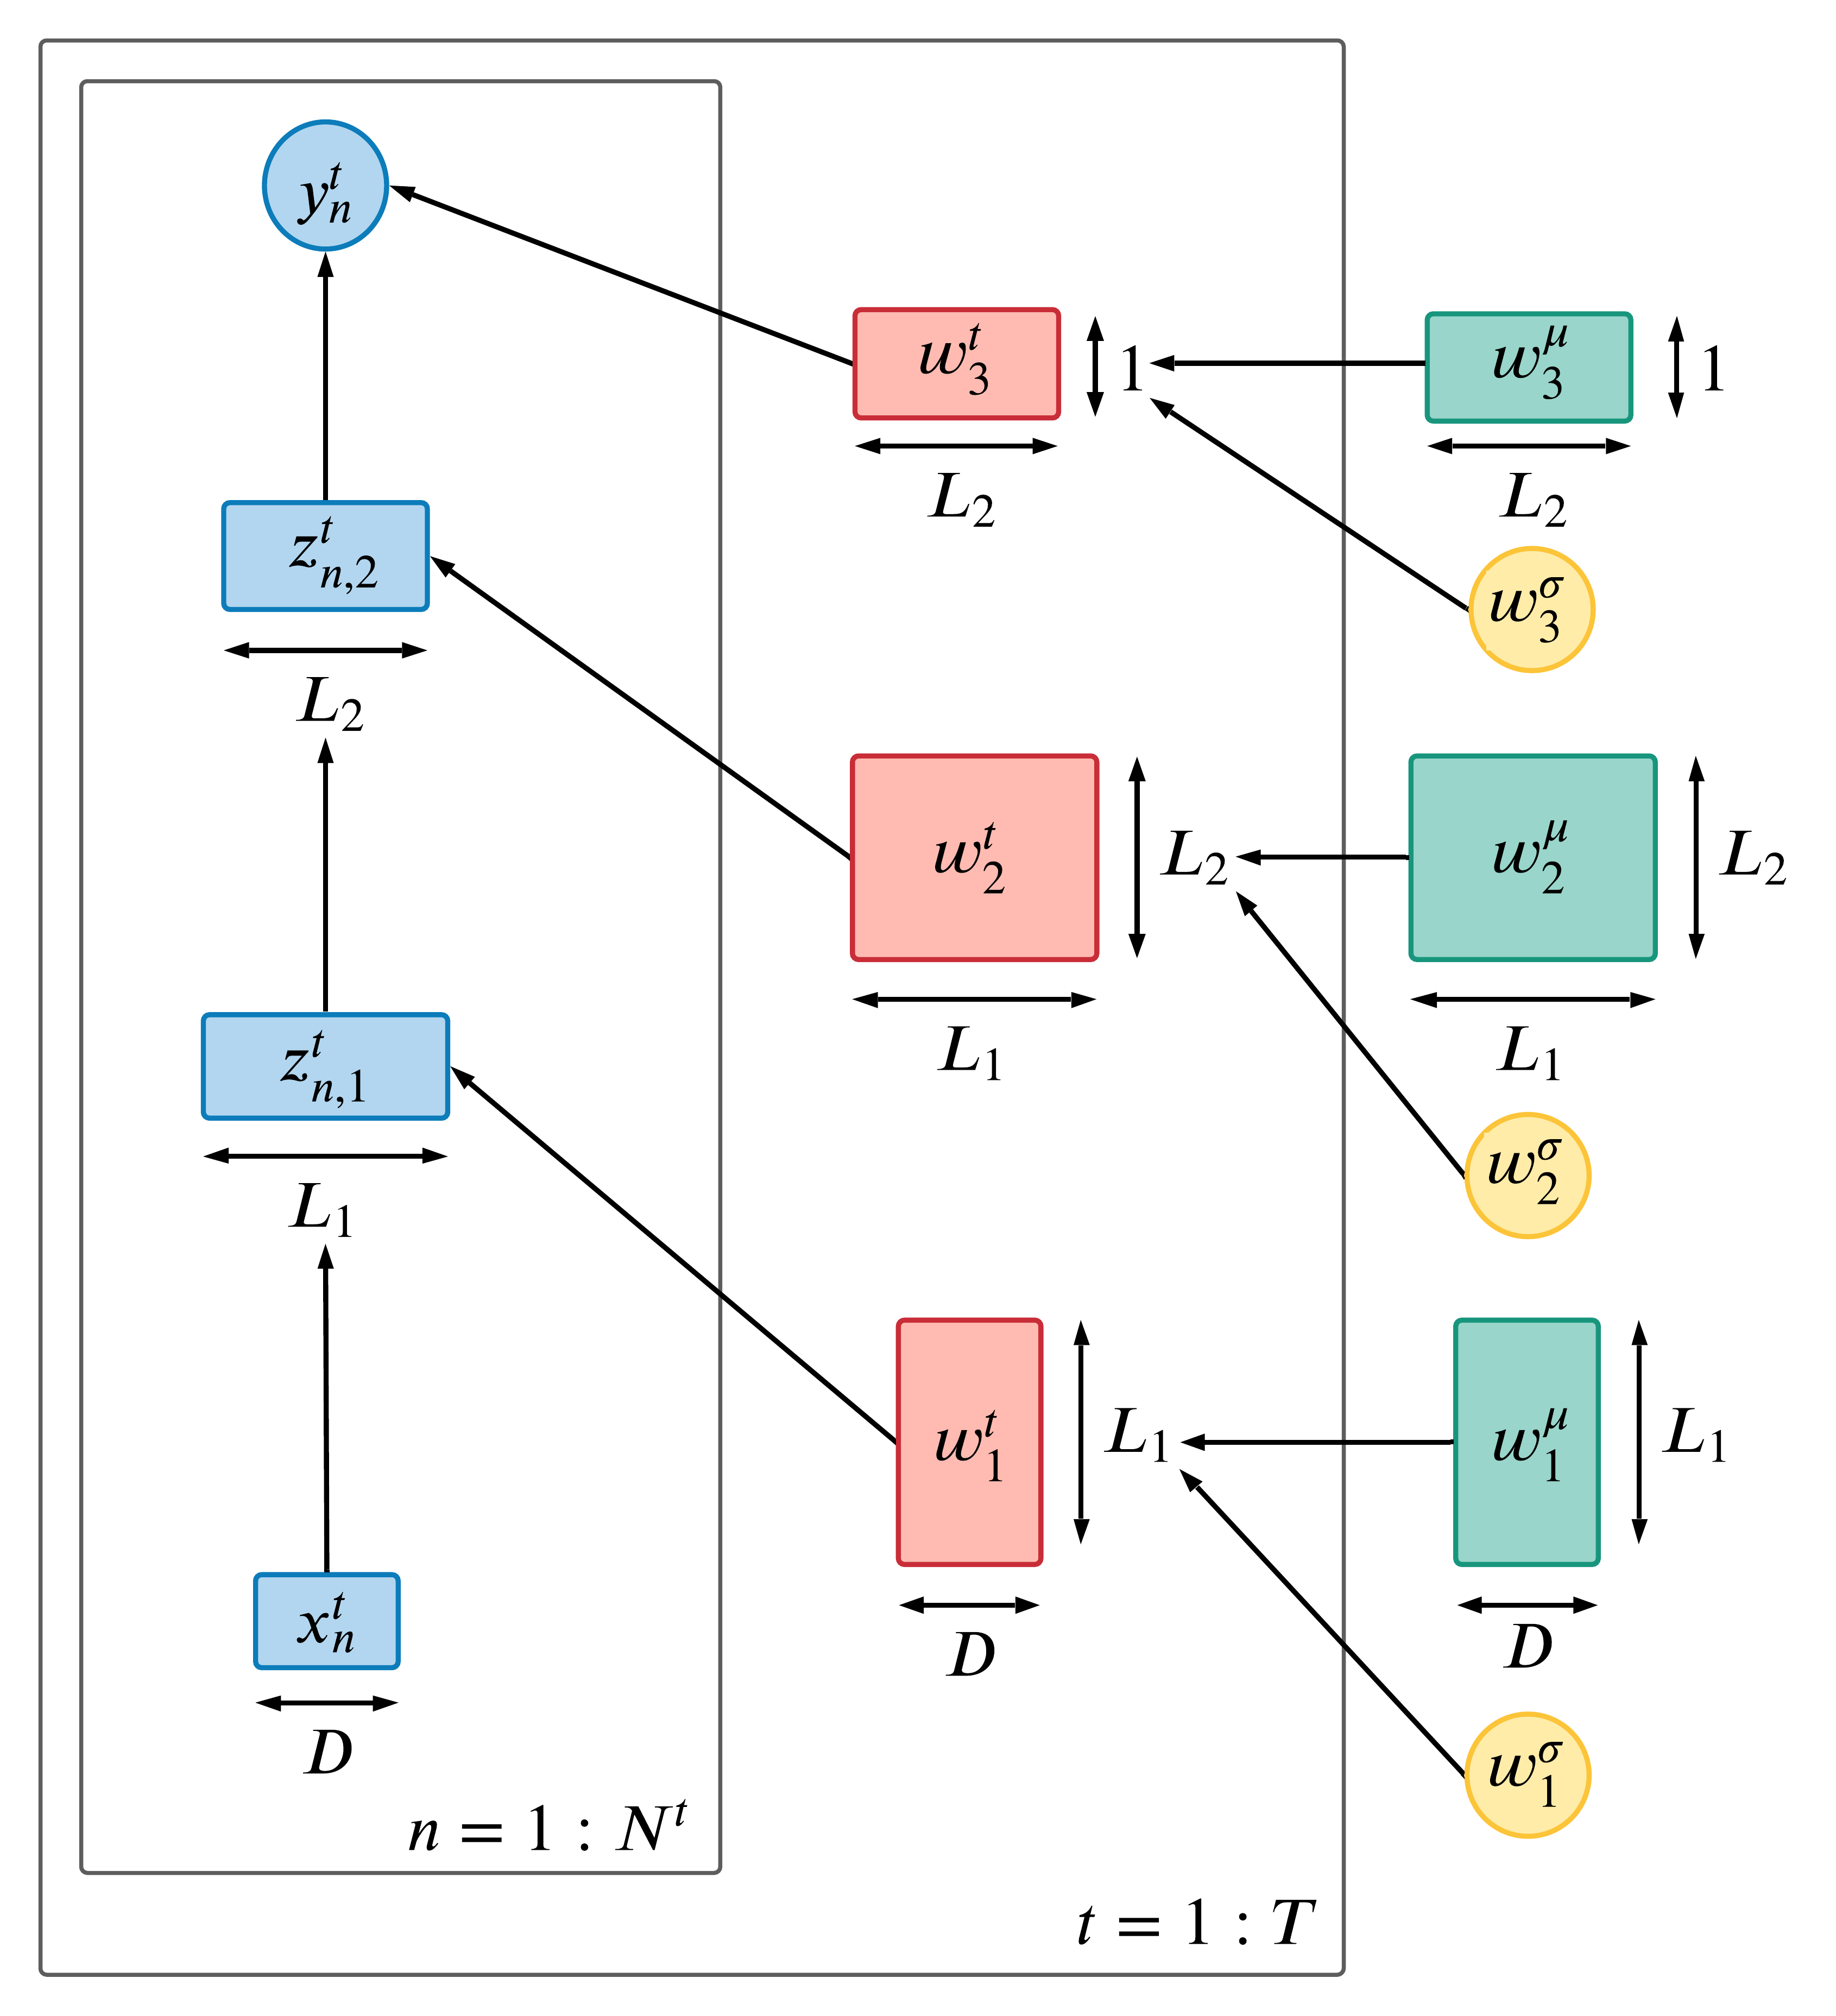

In [40]:
half_normal = distrax.as_distribution(tfd.HalfNormal(1.0))

In [41]:
def init_hierarchical_params(layer_widths, n_groups, rng_key):
    rng_key, *keys = split(rng_key, len(layer_widths))
    params = {}
    for i, (n_in, n_out, key) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys)):
        mu_key, std_key, eps_key = split(key, 3)
        params[f"w_{i}_mu"] = distrax.Normal(0, 1).sample(seed=mu_key, sample_shape=(n_in, n_out))
        params[f"w_{i}_std"] = half_normal.sample(seed=std_key, sample_shape=(1,))
        params[f"w_{i}_eps"] = distrax.Normal(0, 1).sample(seed=eps_key, sample_shape=(n_groups, n_in, n_out))

    return params

In [25]:
def hierarchical_model(params, X, n_hidden_layers):
    n_groups, _, input_dim = X.shape
    output_dim = 1

    z = X

    for i in range(n_hidden_layers + 1):
        w = params[f"w_{i}_mu"] + params[f"w_{i}_eps"] * params[f"w_{i}_std"]
        z = z @ w
        z = jax.nn.tanh(z) if i != n_hidden_layers else z

    z = z.squeeze(-1)
    return z

In [26]:
def logprob_fn_of_hierarchical_model(params, X, Y, model, n_hidden_layers):
    log_joint = 0
    half_normal = distrax.as_distribution(tfd.HalfNormal(1.0))

    for i in range(n_hidden_layers + 1):
        log_joint += distrax.Normal(0.0, 1.0).log_prob(params[f"w_{i}_mu"]).sum()
        log_joint += half_normal.log_prob(params[f"w_{i}_std"]).sum()
        log_joint += distrax.Normal(0.0, 1.0).log_prob(params[f"w_{i}_eps"]).sum()

    z = hierarchical_model(params, X, n_hidden_layers)
    loglikelihood = distrax.Bernoulli(logits=z).log_prob(Y).sum()
    log_joint += loglikelihood

    return jnp.sum(log_joint)

In [27]:
rng_key = PRNGKey(0)
Ys_hierarchical_pred_train, Ys_hierarchical_pred_test, ppc_grid = fit_and_eval(
    rng_key,
    hierarchical_model,
    logprob_fn_of_hierarchical_model,
    Xs_train,
    Ys_train,
    Xs_test,
    grid_3d,
    n_groups=n_groups,
)

### Results

We see that the train and test accuracy are higher, and the decision boundaries all have the shared "Z" shape, as desired.


In [28]:
print("Train accuracy = {:.2f}%".format(100 * jnp.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 91.11%


In [29]:
print("Test accuracy = {:.2f}%".format(100 * jnp.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 89.56%


In [30]:
def plot_decision_surfaces_hierarchical(nrows=1, ncols=4, fname=None):
    figsize = (ncols * 3, nrows * 3)
    s = 20
    if is_latexify_enabled():
        figsize = None
        s = 5
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axes.flatten())):
        contour = ax.contourf(
            grid[:, 0].reshape((100, 100)),
            grid[:, 1].reshape((100, 100)),
            ppc_grid[:, i, :].mean(axis=0).reshape(100, 100),
            cmap=cmap,
        )
        ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], color="b", s=s, label="Class 0")
        ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color="r", s=s, label="Class 1")
        sns.despine()
        ax.set_title("Dataset " + str(i + 1))
    if fname:
        ax.legend(borderaxespad=0.2, handletextpad=0, borderpad=0.2, handlelength=1.5, fontsize=7)
        savefig(fname, tight_layout=False)
    else:
        ax.legend()

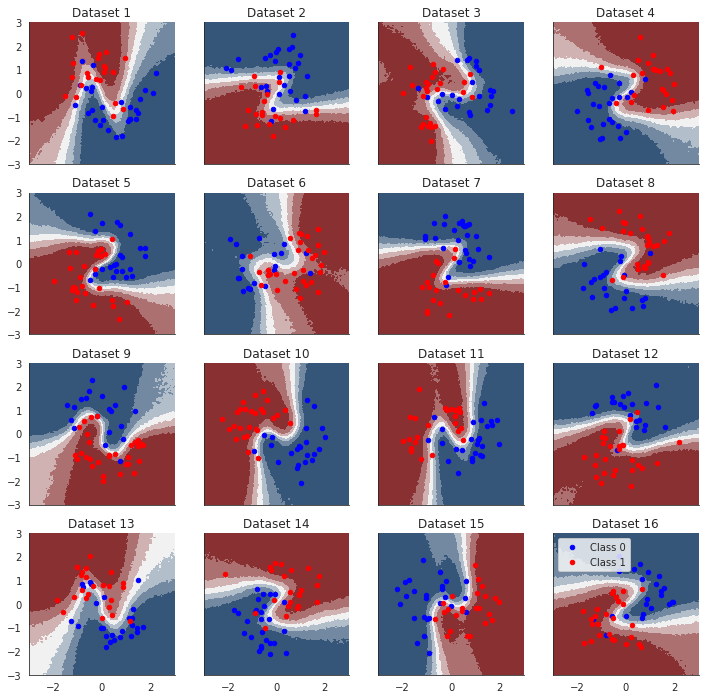

In [31]:
plot_decision_surfaces_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

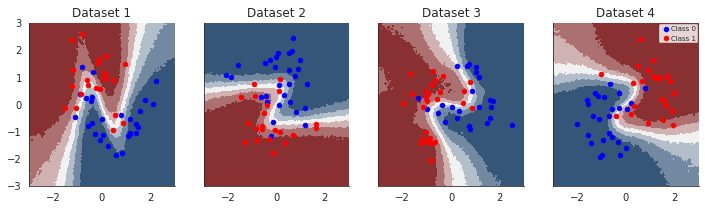

In [32]:
plot_decision_surfaces_hierarchical(fname="Decision_surfaces_hierarchial")

## Hierarchical Model (in Flax)

We repeat the same experiment from the last section, but we implement the MLP using Flax 

In [46]:
try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn

from jax.flatten_util import ravel_pytree

In [43]:
HalfNormal = distrax.as_distribution(tfd.HalfNormal(1.0))

In [224]:
def get_num_layers(params):
    """
    Obtain the number of layers given a set
    of params of a Flax model
    """
    num_layers = len((jax.tree_flatten(params, lambda x: "params" not in x))[0][0])
    return num_layers


def init_hbnn_params(key, model, batch, n_tasks):
    """
    Initialise the parameters of the Hierarchical Bayesian Neural Network
    """
    key_tasks_init, key_params_init, key_sigma_init = jax.random.split(key, 3)
    keys_tasks_init = jax.random.split(key_tasks_init, n_tasks)

    params_tasks = jax.vmap(model.init, (0, None))(keys_tasks_init, batch)
    params_shared = model.init(key_params_init, batch)
    n_layers = get_num_layers(params_shared)
    params_sigma = HalfNormal.sample(seed=key_sigma_init, sample_shape=(n_layers, 2))

    model_treedef = jax.tree_structure(params_shared)

    params_init = {
        "task": params_tasks,
        "noise": params_sigma,
        "shared": params_shared,
    }

    return params_init, model_treedef


def build_sigma_tree(params, treedef):
    """
    Build a tree of parameters that satisfy
    the HBNN conditions and is flax-compatible
    """
    n_layers = len(params)
    map_array = jnp.ones((1, 1, n_layers, 2))
    params_sigma_tree = jnp.einsum("kl,ijkl->ijkl", params, map_array)
    # params_sigma_tree = jnp.concatenate([map_array, params_sigma_tree], axis=-1)
    params_sigma_tree = jax.tree_util.build_tree(treedef, params_sigma_tree)

    return params_sigma_tree


@partial(jax.vmap, in_axes=0)
def vmap_log_likelihood(params, X, y):
    """
    Hierarchical Bayesian neural network log-likelihood

    Parameters
    ----------
    params: pytree
    X: jnp.array(C, N, ...)
        Collection of observations
    y: jnp.array(C, N, ...)
        Collection of outputs
    """
    logits = model.apply(params, X).ravel()
    log_likelihood = distrax.Bernoulli(logits=logits).log_prob(y).sum()
    return log_likelihood


def hierarchical_bnn_log_joint(params, X, y, model):
    """
    Hierarchical Bayesian neural network log-joint. The model
    assumes

    w^t_{ijl} = \mu_{ijl} + \varepsilon^t_{ijl} \sigma_l

    Parameters
    ----------
    parameters: flax.FrozenDict
    X: jnp.array(C, N, ...)
        Collection of observations
    y: jnp.array(C, N, ...)
        Collection of outputs

    Returns
    -------
    float: float
        Log-joint value
    """

    n_layers = get_num_layers(params["shared"])
    shared_tree = params["shared"]
    task_tree = params["task"]
    sigma_tree = build_sigma_tree(params["noise"], model_treedef)

    model_params = jax.tree_map(lambda mu, task, sigma: mu + sigma * task, shared_tree, task_tree, sigma_tree)

    # ** log-likelihood for all tasks **
    log_likelihood_collection = vmap_log_likelihood(model_params, X, y).sum()

    # ** log priors **
    # Tasks priors
    log_task_prior = jax.tree_map(distrax.Normal(0, 1).log_prob, task_tree)
    log_task_prior = ravel_pytree(log_task_prior)[0].sum()
    # Global prior
    log_shared_prior = jax.tree_map(distrax.Normal(0, 1).log_prob, shared_tree)
    log_shared_prior = ravel_pytree(log_shared_prior)[0].sum()
    # Sigma-layered prior
    log_sigma_prior = HalfNormal.log_prob(params["noise"]).sum()

    log_prior = log_task_prior + log_shared_prior + log_sigma_prior
    log_joint = log_likelihood_collection + log_prior
    return log_joint


def build_model_params(params, treedef, n_layers):
    """
    Aggregate dictionary of parameters into a
    Flax-valid set of parameters.

    Parameters
    ----------
    params: dict
        Colletion of parameters for the HBNN as
        specified by `init_hbnn_params`

    Returns
    -------
    flax.FrozenDict: flax-compatible set of weights
    """
    shared_tree = params["shared"]
    task_tree = params["task"]
    sigma_tree = build_sigma_tree(params["noise"], treedef)

    model_params = jax.tree_map(lambda mu, task, sigma: mu + sigma * task, shared_tree, task_tree, sigma_tree)
    return model_params


@partial(jax.vmap, in_axes=(0, None, None))
def eval_hbnn_tasks(params, X, treedef):
    n_layers = get_num_layers(params["shared"])
    model_params = build_model_params(params, treedef, n_layers)
    return jax.vmap(model.apply, 0)(model_params, X)


@partial(jax.vmap, in_axes=(None, 2, None), out_axes=2)
@partial(jax.vmap, in_axes=(None, 1, None), out_axes=1)
@partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def eval_hbnn_grid(params, X, treedef):
    n_layers = get_num_layers(params["shared"])
    model_params = build_model_params(params, treedef, n_layers)
    return jax.vmap(model.apply, (0, None))(model_params, X)

In [225]:
key = jax.random.PRNGKey(0)
key_model_init, key_state_init, key_sample = jax.random.split(key, 3)

In [226]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.tanh(nn.Dense(5)(x))
        x = nn.tanh(nn.Dense(5)(x))
        x = nn.Dense(1)(x)
        return x


model = MLP()
batch = jnp.ones((n_samples, 2))
params_all, model_treedef = init_hbnn_params(key_model_init, model, batch, n_groups)

In [260]:
%%time
num_warmup = 3000
num_samples = 500

potential = partial(hierarchical_bnn_log_joint, X=Xs_train, y=Ys_train, model=model)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_state_init, params_all)

states = inference_loop(key_sample, kernel, final_state, num_samples)
sampled_params = states.position

CPU times: user 21.9 s, sys: 529 ms, total: 22.4 s
Wall time: 35.7 s


In [261]:
logits_test = eval_hbnn_tasks(sampled_params, Xs_test, model_treedef)
logits_train = eval_hbnn_tasks(sampled_params, Xs_train, model_treedef)

Ys_hat_pred_test = nn.sigmoid(logits_test).mean(axis=0)[..., 0] > 0.5
Ys_hat_pred_train = nn.sigmoid(logits_train).mean(axis=0)[..., 0] > 0.5

## Train / test results

In [262]:
print("Train accuracy = {:.2f}%".format(100 * jnp.mean(Ys_hat_pred_train == Ys_train)))

Train accuracy = 91.00%


In [263]:
print("Test accuracy = {:.2f}%".format(100 * jnp.mean(Ys_hat_pred_test == Ys_test)))

Test accuracy = 89.56%
